# **Projeto de Previsão de Demanda**
---

# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import plotnine as p9
from statsmodels.tsa.seasonal import STL
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Configurações de ambiente

In [ ]:
pd.options.display.float_format = '{:.2f}'.format

# Coleta de Dados

In [ ]:
# Fonte dos dados: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting
df_bruto = pd.read_csv("https://aluno.analisemacro.com.br/download/69280/?tmstv=1768230842", compression = "zip")
df_bruto.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500


# Tramento de Dados

In [ ]:
df_tratado = (
    df_bruto
    .copy()
    .assign(
        Date = lambda x: pd.to_datetime(x["Date"], format = "%Y/%m/%d"),
        Order_Demand = lambda x: x.Order_Demand.str.replace("\\(", "", regex = True).str.replace("\\)", "", regex = True).astype(int)
    )
)
df_tratado

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012-07-27,100
1,Product_0979,Whse_J,Category_028,2012-01-19,500
2,Product_0979,Whse_J,Category_028,2012-02-03,500
3,Product_0979,Whse_J,Category_028,2012-02-09,500
4,Product_0979,Whse_J,Category_028,2012-03-02,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016-04-27,1000
1048571,Product_1974,Whse_J,Category_006,2016-04-27,1
1048572,Product_1787,Whse_J,Category_006,2016-04-28,2500
1048573,Product_0901,Whse_J,Category_023,2016-10-07,50


# Análise Exploratória

In [ ]:
# Quantos produtos tem?
df_tratado.Product_Code.nunique()

2160

In [ ]:
# Quantas categorias de produto tem?
df_tratado.Product_Category.nunique()

33

In [ ]:
# Estatística descritiva
stat_desc = df_tratado.describe(include = "all")
stat_desc

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
count,1048575,1048575,1048575,1037336,1048575.00
unique,2160,4,33,NaN,NaN
top,Product_1359,Whse_J,Category_019,NaN,NaN
freq,16936,764447,481099,NaN,NaN
mean,NaN,NaN,NaN,2014-06-17 05:14:07.756175104,4906.98
min,NaN,NaN,NaN,2011-01-08 00:00:00,0.00
25%,NaN,NaN,NaN,2013-04-05 00:00:00,20.00
50%,NaN,NaN,NaN,2014-06-10 00:00:00,300.00
75%,NaN,NaN,NaN,2015-08-26 00:00:00,2000.00
max,NaN,NaN,NaN,2017-01-09 00:00:00,4000000.00


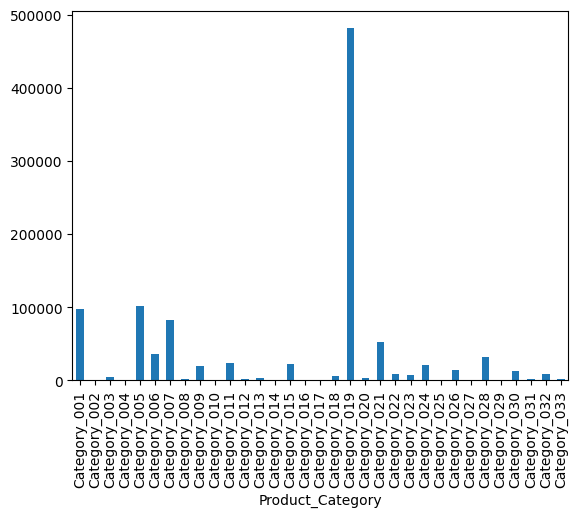

In [ ]:
# Qtd demandada de cada categoria de produto
df_tratado.groupby("Product_Category")["Order_Demand"].count().plot.bar();

In [ ]:
# Análise temporal da categoria mais representativa
categoria_alvo = stat_desc.loc["top", "Product_Category"]
df_alvo = (
    df_tratado
    .query("Product_Category == @categoria_alvo")
    .groupby("Date")
    .Order_Demand
    .sum()
    .to_frame()
    .query("Date >= @pd.to_datetime('2012-01-01')")
    .Order_Demand
    .resample("W")
    .sum()
    .to_frame()
    .query("index <= @pd.to_datetime('2017-01-01')")
)
df_alvo

,Order_Demand
Date,
2012-01-08,14645930
2012-01-15,13311701
2012-01-22,13501581
2012-01-29,11039627
2012-02-05,17870601
...,...
2016-12-04,20243570
2016-12-11,17484566
2016-12-18,17200229


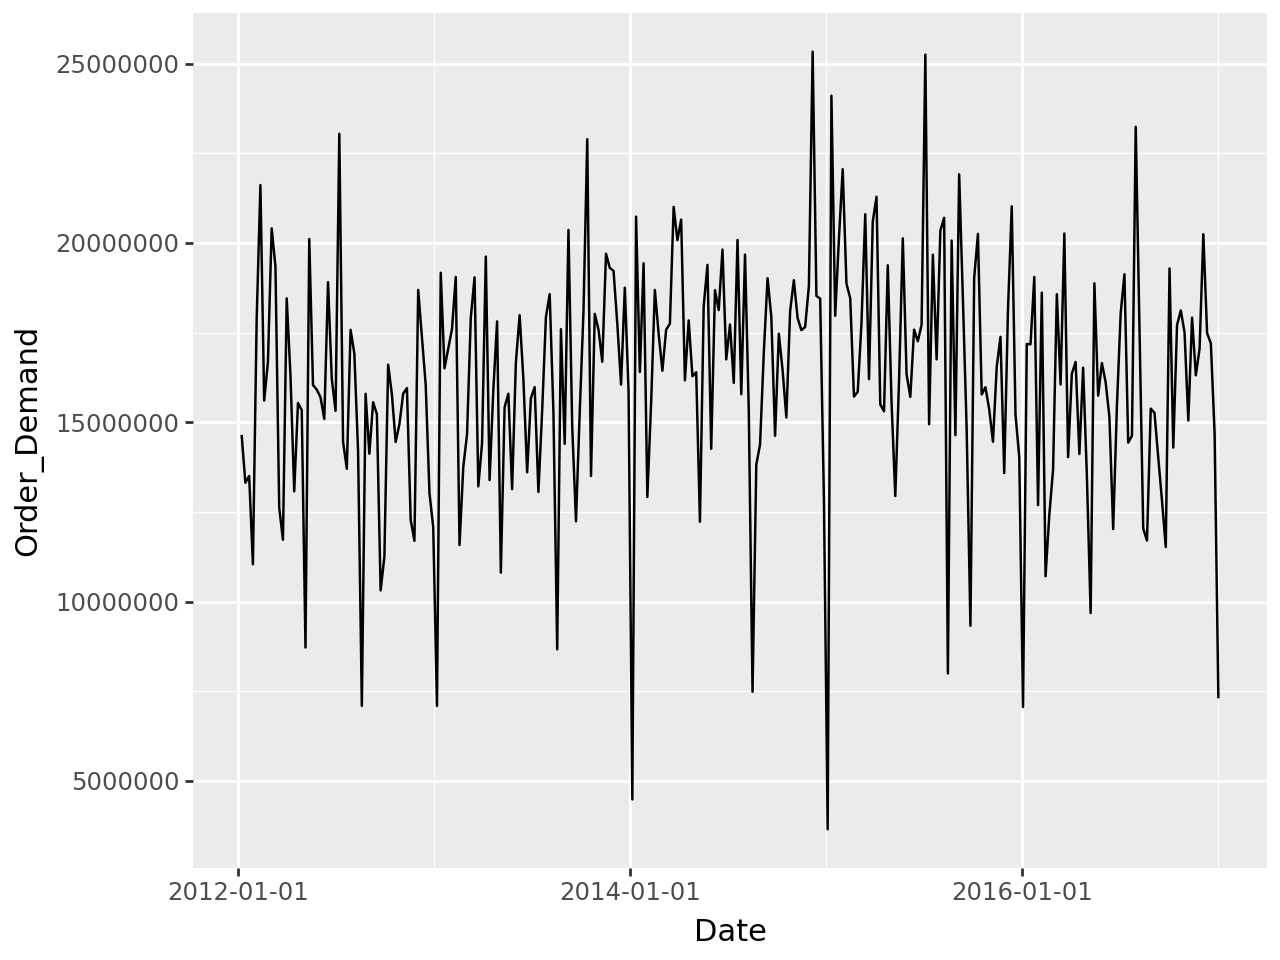

In [ ]:
# Gráfico temporal
(
    p9.ggplot(df_alvo.reset_index()) +
    p9.aes(x = "Date", y = "Order_Demand") +
    p9.geom_line()
)

In [ ]:
# Estatística descritiva
df_alvo.describe()

,Order_Demand
count,261.00
mean,16220004.45
std,3314127.16
min,3645912.00
25%,14456986.00
50%,16306116.00
75%,18238018.00
max,25335240.00


/usr/local/lib/python3.12/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 19'. Pick better value with 'binwidth'.


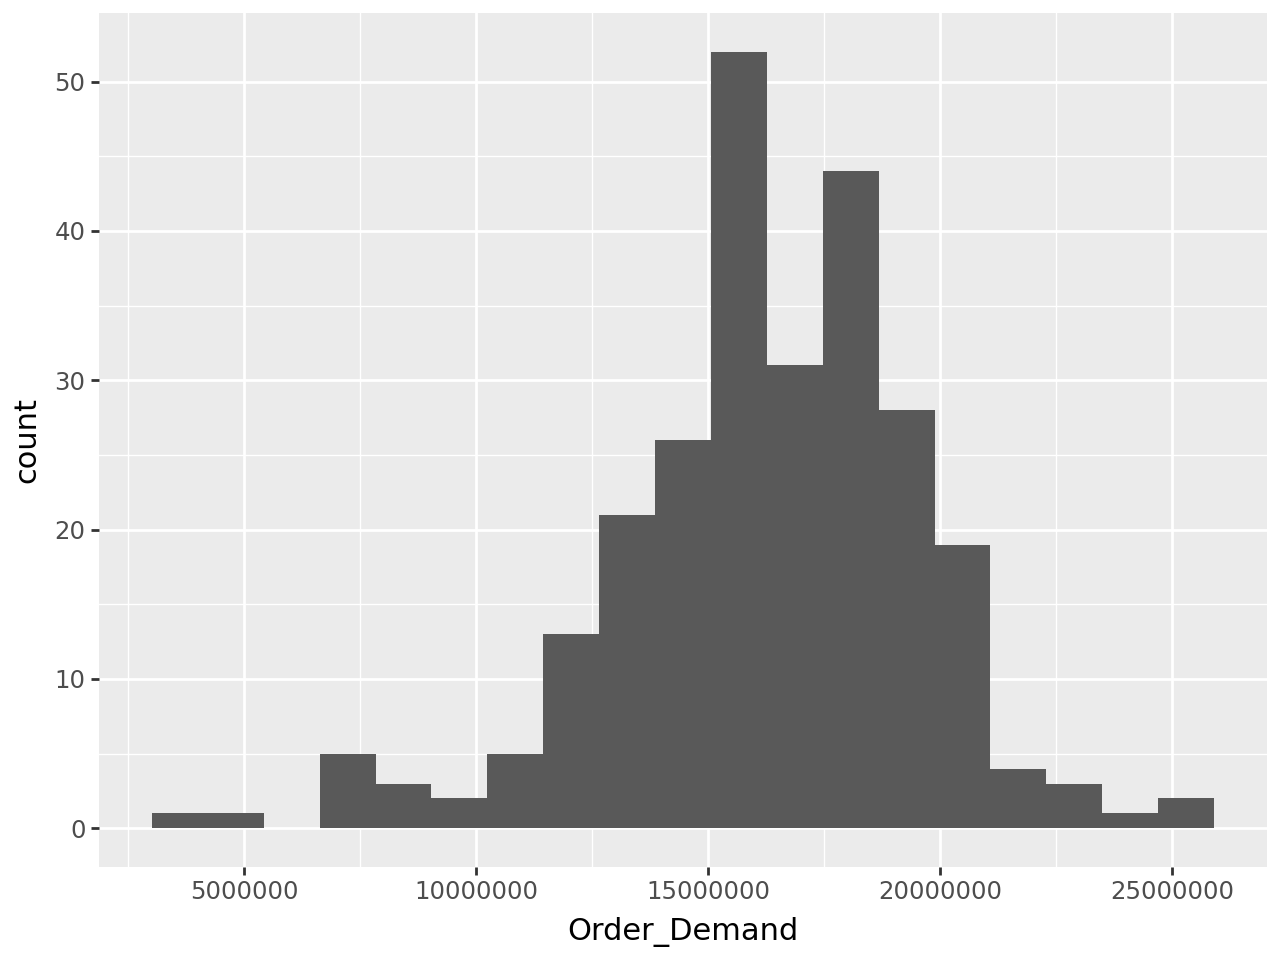

In [ ]:
# Gráfico de histograma
(
    p9.ggplot(df_alvo.reset_index()) +
    p9.aes(x = "Order_Demand") +
    p9.geom_histogram()
)

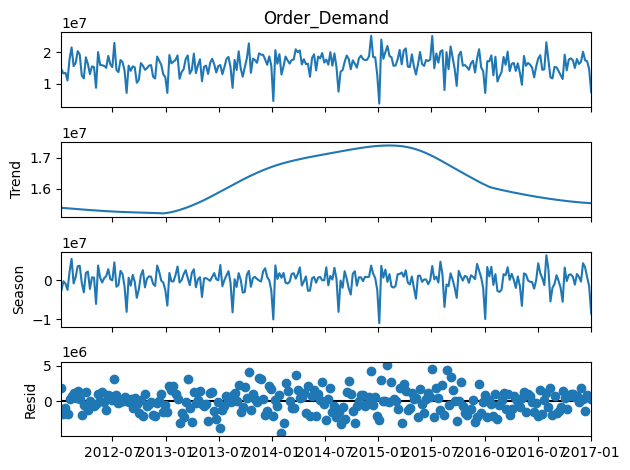

In [ ]:
# Análise de sazonalidade
stl = STL(df_alvo.Order_Demand, period = 52).fit()
stl.plot();

# Modelo Preditivo

In [ ]:
# Criar regressores
month = df_alvo.index.month
df_regressao = (
    df_alvo
    .copy()
    .assign(
        tendencia = lambda x: ((df_alvo.reset_index().index + 1) + df_alvo.Order_Demand.mean()),
        sazonalidade = np.sin(2 * np.pi * month / 12)
        )
)
df_regressao

,Order_Demand,tendencia,sazonalidade
Date,,,
2012-01-08,14645930,16220005.45,0.50
2012-01-15,13311701,16220006.45,0.50
2012-01-22,13501581,16220007.45,0.50
2012-01-29,11039627,16220008.45,0.50
2012-02-05,17870601,16220009.45,0.87
...,...,...,...
2016-12-04,20243570,16220261.45,-0.00
2016-12-11,17484566,16220262.45,-0.00
2016-12-18,17200229,16220263.45,-0.00


In [ ]:
# Separa amostras treino/teste
df_treino = df_regressao.query("index <= @pd.to_datetime('2015-01-01')").copy()
df_teste = df_regressao.query("index > @pd.to_datetime('2015-01-01')").copy()
df_treino

,Order_Demand,tendencia,sazonalidade
Date,,,
2012-01-08,14645930,16220005.45,0.50
2012-01-15,13311701,16220006.45,0.50
2012-01-22,13501581,16220007.45,0.50
2012-01-29,11039627,16220008.45,0.50
2012-02-05,17870601,16220009.45,0.87
...,...,...,...
2014-11-30,18799081,16220156.45,-0.50
2014-12-07,25335240,16220157.45,-0.00
2014-12-14,18523615,16220158.45,-0.00


In [ ]:
# Regressão linear (fit)
modelo_rl = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("regressor", LinearRegression())
])
modelo_rl.fit(df_treino[["tendencia", "sazonalidade"]], df_treino["Order_Demand"])

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

In [ ]:
# Regressão linear (forecast)
y_prev_rl = modelo_rl.predict(df_teste[["tendencia", "sazonalidade"]])
y_prev_rl

array([17941325.09550681, 17960545.7042691 , 17979766.31303138,
       17998986.92179366, 18245430.12897022, 18264650.73773251,
       18283871.34649479, 18303091.95525707, 18405481.80735289,
       18424702.41611517, 18443923.02487746, 18463143.63363974,
       18482364.24240202, 18418415.60783077, 18437636.21659305,
       18456856.82535533, 18476077.43411761, 18268075.44446561,
       18287296.05322789, 18306516.66199017, 18325737.27075246,
       18344957.87951474, 18053786.6465292 , 18073007.25529148,
       18092227.86405377, 18111448.47281605, 17820277.23983051,
       17839497.84859279, 17858718.45735507, 17877939.06611736,
       17669937.07646535, 17689157.68522764, 17708378.29398992,
       17727598.9027522 , 17746819.51151448, 17682870.87694323,
       17702091.48570551, 17721312.09446779, 17740532.70323008,
       17842922.5553259 , 17862143.16408817, 17881363.77285046,
       17900584.38161274, 18147027.58878931, 18166248.19755159,
       18185468.80631387, 18204689.41507

In [ ]:
# Modelo ETS (fit)
modelo_ets = ExponentialSmoothing(
    df_treino.Order_Demand,
    trend = "add",
    seasonal = "add",
    seasonal_periods = 52
).fit(optimized = True)
modelo_ets

In [ ]:
# Modelo ETS (forecast)
y_prev_ets = modelo_ets.forecast(len(df_teste))
y_prev_ets

,0
2015-01-04,6997004.71
2015-01-11,21191416.04
2015-01-18,17666808.05
2015-01-25,19445081.74
2015-02-01,16472549.52
...,...
2016-12-04,20024373.60
2016-12-11,18499930.77
2016-12-18,18344245.91
2016-12-25,16407151.12


# Avaliação e Diagnóstico

In [ ]:
df_previsao = (
    pd.Series(y_prev_rl, index = df_teste.index)
    .rename("RL")
    .to_frame()
    .join(y_prev_ets.rename("ETS"))
    .join(df_teste["Order_Demand"])
)
df_previsao

,RL,ETS,Order_Demand
Date,,,
2015-01-04,17941325.10,6997004.71,3645912
2015-01-11,17960545.70,21191416.04,24107548
2015-01-18,17979766.31,17666808.05,17968822
2015-01-25,17998986.92,19445081.74,20127321
2015-02-01,18245430.13,16472549.52,22057334
...,...,...,...
2016-12-04,19552994.13,20024373.60,20243570
2016-12-11,19572214.74,18499930.77,17484566
2016-12-18,19591435.35,18344245.91,17200229


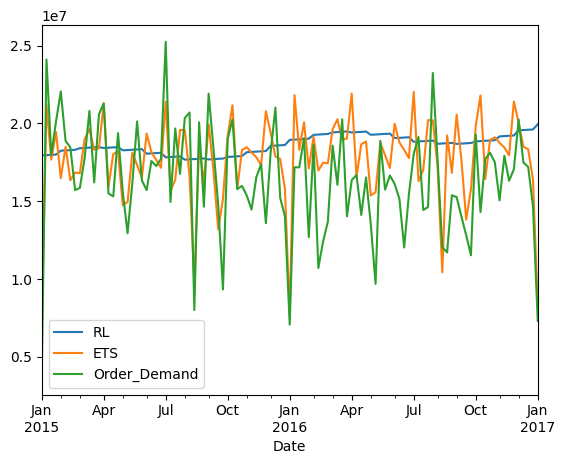

In [ ]:
df_previsao.plot();

In [ ]:
# Cálculo de métricas de erro
y_true = df_previsao.Order_Demand
y_pred_rl = df_previsao.RL
y_pred_ets = df_previsao.ETS
print("Métricas RL")
print(f"Erro médio: {np.mean(y_true - y_pred_rl)}")
print(f"Erro médio absoluto: {np.mean(np.abs(y_true - y_pred_rl))}")
print(f"Raiz do erro médio quadrático: {np.sqrt(np.mean((y_true - y_pred_rl)**2))}\n\n")

print("Métricas ETS")
print(f"Erro médio: {np.mean(y_true - y_pred_ets)}")
print(f"Erro médio absoluto: {np.mean(np.abs(y_true - y_pred_ets))}")
print(f"Raiz do erro médio quadrático: {np.sqrt(np.mean((y_true - y_pred_ets)**2))}\n\n")

Métricas RL
Erro médio: -2260637.3426040187
Erro médio absoluto: 3361498.123776261
Raiz do erro médio quadrático: 4332812.766586322


Métricas ETS
Erro médio: -1347914.6369664418
Erro médio absoluto: 2365838.7776166955
Raiz do erro médio quadrático: 3013209.444502043




In [ ]:
# Previsão fora da amostra
# Modelo ETS (fit)
modelo_ets_final = ExponentialSmoothing(
    df_alvo.Order_Demand,
    trend = "add",
    seasonal = "add",
    seasonal_periods = 52
).fit(optimized = True)

y_prev_ets = modelo_ets_final.forecast(52)
y_prev_ets

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:903: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.


,0
2017-01-08,20339326.67
2017-01-15,17042660.88
2017-01-22,18955363.36
2017-01-29,16349613.44
2017-02-05,18027837.47
2017-02-12,14852672.20
2017-02-19,14833939.61
2017-02-26,15162714.41
2017-03-05,17962182.42
2017-03-12,18422857.74


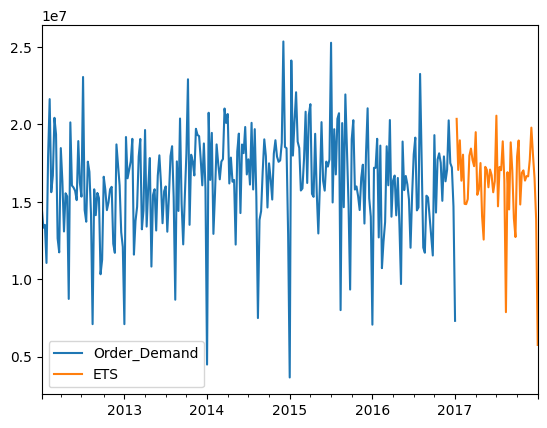

In [ ]:
df_alvo.join(y_prev_ets.rename("ETS"), how = "outer")[["Order_Demand", "ETS"]].plot();

# Comunicação de Resultados

#